# Model Selection, Metrics, and Experiment Tracking with MLflow

## Overview
This notebook demonstrates an end-to-end workflow for:
- evaluating classification metrics under class imbalance,
- tuning models with cross-validation (GridSearchCV),
- comparing multiple classifiers,
- tracking experiments with MLflow,
- visualizing underfitting vs overfitting using synthetic data.

The goal is to present a portfolio-ready machine learning workflow rather than coursework instructions.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

## 1. Data Loading

> **Dataset note:** The original dataset files are not included in this repository due to size limitations.
>  
> To run this notebook locally, place:
> - `nurse_data_train.csv`
> - `nurse_data_test.csv`
> in the same directory as this notebook (or update the file paths below).

In [ ]:
df_x_train = pd.read_csv('nurse_data_train.csv')
df_x_test = pd.read_csv('nurse_data_test.csv')

y_train=np.array(df_x_train['label'])
df_x_train=df_x_train.drop('label', axis=1)
y_test=np.array(df_x_test['label'])
df_x_test=df_x_test.drop('label', axis=1)

from sklearn.preprocessing import MinMaxScaler

min_max=MinMaxScaler().fit(df_x_train)
df_x_train=min_max.transform(df_x_train)
df_x_test=min_max.transform(df_x_test)

In [6]:
df_x_train.shape, df_x_test.shape

((267424, 19), (89142, 19))

## 2. Why Accuracy Can Be Misleading (Class Imbalance)

In imbalanced classification problems, accuracy may appear high even when the model fails completely on a minority class.

This happens because:
- the model predicts the majority class most of the time,
- correct majority predictions dominate the score,
- minority-class errors become “invisible” in accuracy.

To properly evaluate performance, we use:
- **Precision / Recall**
- **F1-score (macro)**
- **Balanced Accuracy**
- **Cohen’s Kappa**
- **ROC-AUC (OvR for multiclass)**
and we always inspect the **confusion matrix**.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### Baseline Model (Decision Tree) + Confusion Matrix

We start with a simple baseline model to demonstrate the issue:
high accuracy can coexist with near-zero performance on a minority class.

The confusion matrix is the fastest way to detect this failure mode.

accuracy na zbiorze testowym: 77.4 %


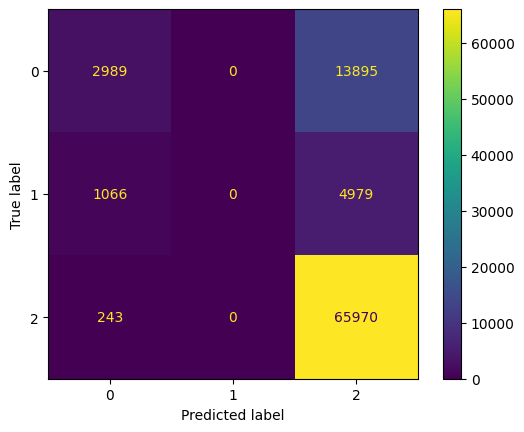

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model=DecisionTreeClassifier(random_state=42, max_depth=2)
model.fit(df_x_train, y_train)

print('accuracy na zbiorze testowym: {} %'.format(round(accuracy_score(y_test, model.predict(df_x_test))*100, 1)))

cm = confusion_matrix(y_test, model.predict(df_x_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

### Metrics Better Suited for Imbalanced Classification

We report multiple metrics because each captures a different aspect:
- **Recall** is critical when missing a class is costly,
- **F1 (macro)** weights each class equally,
- **Cohen’s Kappa** accounts for chance agreement,
- **ROC-AUC (OvR)** measures ranking quality across classes.

This gives a more realistic view than accuracy alone.

In [ ]:
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    cohen_kappa_score
)

y_pred = model.predict(df_x_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in model.classes_]))

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {round(kappa, 3)}")

try:
    y_prob = model.predict_proba(df_x_test) 
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"ROC-AUC: {round(roc_auc, 3)}")
except AttributeError:
    print("Model nie obsługuje przewidywania prawdopodobieństw (predict_proba). ROC-AUC nie zostało obliczone.")

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.18      0.28     16884
           1       0.00      0.00      0.00      6045
           2       0.78      1.00      0.87     66213

    accuracy                           0.77     89142
   macro avg       0.49      0.39      0.39     89142
weighted avg       0.71      0.77      0.70     89142

Cohen's Kappa: 0.202
ROC-AUC: 0.648


In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

### Handling Imbalance with SMOTE (Optional)

SMOTE synthetically generates samples of the minority class to reduce imbalance.

This can improve minority-class recall, but may also:
- introduce noisy synthetic points,
- increase overfitting risk.

We treat SMOTE as an optional experiment and evaluate it using the same metrics and confusion matrix.

Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.83      0.58     16884
           1       0.56      0.90      0.69      6045
           2       0.94      0.68      0.79     66213

    accuracy                           0.72     89142
   macro avg       0.65      0.80      0.69     89142
weighted avg       0.82      0.72      0.74     89142

Cohen's Kappa: 0.471
ROC-AUC: 0.92


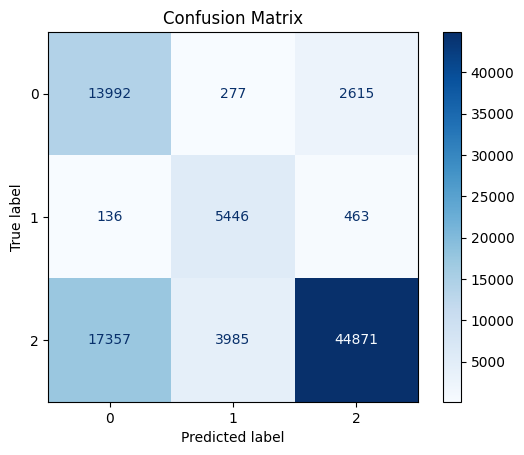

In [ ]:
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_x_train, y_train)

model = DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(df_x_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in model.classes_]))

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {round(kappa, 3)}")

try:
    y_prob = model.predict_proba(df_x_test)  
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"ROC-AUC: {round(roc_auc, 3)}")
except AttributeError:
    print("Model nie obsługuje przewidywania prawdopodobieństw (predict_proba). ROC-AUC nie zostało obliczone.")

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 3. Hyperparameter Tuning with Cross-Validation (GridSearchCV)

We tune models using **cross-validation** because a single train/test split can produce unstable estimates.

Cross-validation:
- trains the model on multiple folds,
- evaluates on held-out folds,
- reduces variance of the evaluation,
- helps select hyperparameters that generalize better.

We compare multiple models using GridSearchCV with a consistent scoring metric (**F1-macro**).

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':[1, 5, 10, 20, 30]}
model_tree = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(model_tree, parameters,
                  scoring='accuracy', cv=6)
clf.fit(df_x_train, y_train)

GridSearchCV(cv=6, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': [1, 5, 10, 20, 30]},
             scoring='accuracy')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]}

model_rf = RandomForestClassifier(random_state=42)
clf_rf = GridSearchCV(model_rf, parameters_rf, scoring='accuracy', cv=6)
clf_rf.fit(df_x_train, y_train)

In [47]:
from sklearn.neural_network import MLPClassifier

parameters_mlp = {'hidden_layer_sizes': [(1,), (2,), (3,)], 'activation': ['relu', 'tanh']}

model_mlp = MLPClassifier(random_state=42, max_iter=100)
clf_mlp = GridSearchCV(model_mlp, parameters_mlp, scoring='accuracy', cv=6, n_jobs=-1)
clf_mlp.fit(df_x_train, y_train)

2025/01/31 10:54:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2bdd256edf364329b4456ae65095f9ae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/31 11:00:44 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


🏃 View run treasured-crow-909 at: http://127.0.0.1:5000/#/experiments/0/runs/f1e8dc689c5b40529504e69c00063838
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bold-sponge-404 at: http://127.0.0.1:5000/#/experiments/0/runs/83d6b26e80a44655939336c87ea78978
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run lyrical-grub-875 at: http://127.0.0.1:5000/#/experiments/0/runs/17ded0c1150b4ec1b809f973f07f6ebd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run fun-bug-578 at: http://127.0.0.1:5000/#/experiments/0/runs/3a5721011f664f8ea593a2181554d0a9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


🏃 View run charming-kite-587 at: http://127.0.0.1:5000/#/experiments/0/runs/04ee368f6d4844779cbef4783171f336
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run capricious-finch-5 at: http://127.0.0.1:5000/#/experiments/0/runs/84cce0f6b1034430b5df8e73eb751886
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run able-yak-207 at: http://127.0.0.1:5000/#/experiments/0/runs/acae6de4d4c945fb9d6d35a251134359
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run unequaled-turtle-96 at: http://127.0.0.1:5000/#/experiments/0/runs/dd3466726c8345888d90809a860c45dc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run melodic-shrimp-567 at: http://127.0.0.1:5000/#/experiments/0/runs/27ce4aefde8447629215dfd372c80c65
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


🏃 View run caring-skunk-269 at: http://127.0.0.1:5000/#/experiments/0/runs/2bdd256edf364329b4456ae65095f9ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


GridSearchCV(cv=6, estimator=MLPClassifier(max_iter=100, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(1,), (2,), (3,)]},
             scoring='accuracy')

In [ ]:
from sklearn.linear_model import LogisticRegression

parameters_lr = {'C': [0.1, 1], 'penalty': ['l1', 'l2']}

model_lr = LogisticRegression(random_state=42, solver='saga')
clf_lr = GridSearchCV(model_lr, parameters_lr, scoring='accuracy', cv=6, n_jobs=-1)
clf_lr.fit(df_x_train, y_train)

In [ ]:
from sklearn.svm import SVC

parameters_svc = {'C': [0, 1], 'kernel': ['linear']}

model_svc = SVC(random_state=42)
clf_svc = GridSearchCV(model_svc, parameters_svc, scoring='accuracy', cv=6, n_jobs=-1)
clf_svc.fit(df_x_train, y_train)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

parameters_knn = {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}

model_knn = KNeighborsClassifier(algorithm='auto')
clf_knn = GridSearchCV(model_knn, parameters_knn, scoring='accuracy', cv=6, n_jobs=-1)
clf_knn.fit(df_x_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [35]:
clf_knn.cv_results_

{'mean_fit_time': array([0.17598061, 0.25087504, 0.27957511, 0.15165114]),
 'std_fit_time': array([0.02980317, 0.10126218, 0.09174375, 0.03535576]),
 'mean_score_time': array([136.20915683, 187.2907418 , 150.32103602, 110.69335588]),
 'std_score_time': array([26.64960123,  9.1668569 , 28.33069306,  1.2196423 ]),
 'param_n_neighbors': masked_array(data=[3, 3, 5, 5],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3, 'weights': 'uniform'},
  {'n_neighbors': 3, 'weights': 'distance'},
  {'n_neighbors': 5, 'weights': 'uniform'},
  {'n_neighbors': 5, 'weights': 'distance'}],
 'split0_test_score': array([0.99712818, 0.99750959, 0.99609612, 0.99690382]),
 'split1_test_score': array([0.9967692 , 0.99712818, 0.99589419, 0.99649997]),
 'split2_test_score': a

In [ ]:
def func_plot_gridsearch(results):
    params=['param_'+ i for i in results['params'][0].keys()]
    
    df=pd.DataFrame()
    df['mean_valid_score']=results['mean_test_score']
    df['fit_time']=results['mean_fit_time']
    
    for p in params:
        df[p]=results[p]
    display(df)
    
    for p in params:
        fig, ax = plt.subplots(figsize=(10,8))
        sns.scatterplot(df,
                        x=p,
                        y='mean_valid_score',
                        hue='fit_time',
                        legend='brief'
                        )
        plt.show()

In [ ]:
def func_plot_gridsearch(results):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    params = ['param_' + i for i in results['params'][0].keys()]
    
    df = pd.DataFrame()
    df['mean_valid_score'] = results['mean_test_score']
    df['fit_time'] = results['mean_fit_time']
    
    for p in params:
        if p == 'param_hidden_layer_sizes': 
            df[p] = [x[0] for x in results[p]] 
        else:
            df[p] = results[p]

    display(df)

    for p in params:
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(data=df,
                        x=p,
                        y='mean_valid_score',
                        hue='fit_time',
                        legend='brief'
                        )
        plt.show()

,mean_valid_score,fit_time,param_n_neighbors,param_weights
0,0.997005,0.175981,3,uniform
1,0.997326,0.250875,3,distance
2,0.996100,0.279575,5,uniform
3,0.996784,0.151651,5,distance


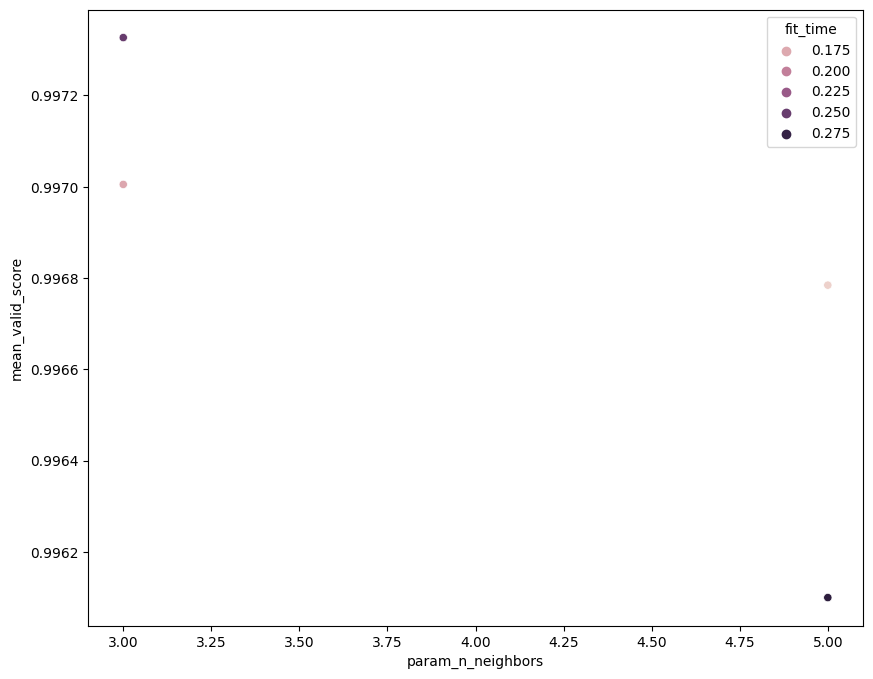

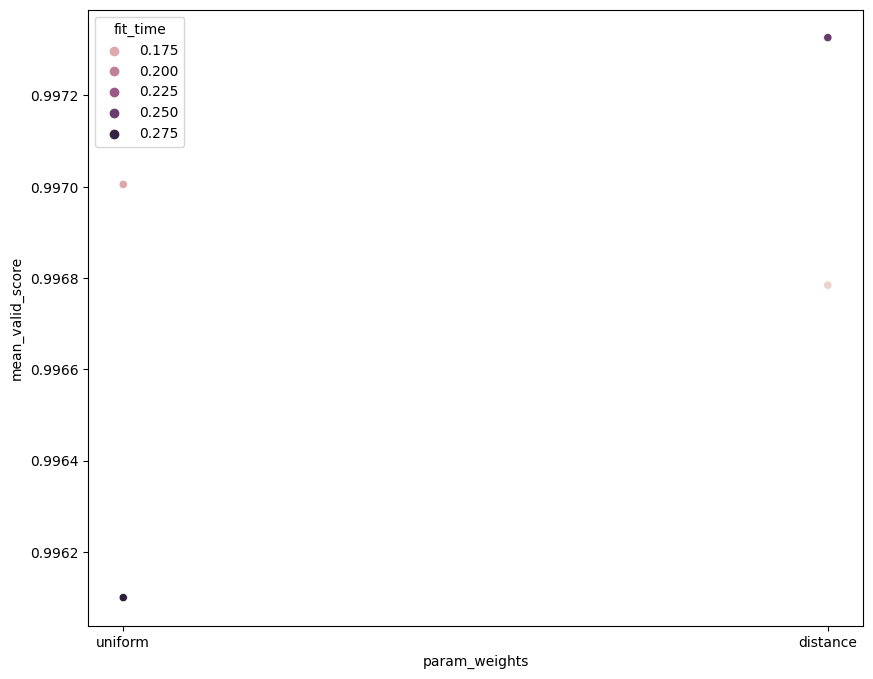

In [36]:
func_plot_gridsearch(clf_knn.cv_results_)

In [ ]:
pip install mlflow

## 4. Experiment Tracking with MLflow

We use **MLflow** to log:
- parameters (GridSearchCV),
- metrics (F1-macro),
- model artifacts (via sklearn autologging).

To run MLflow locally:
1. Install: `pip install mlflow`
2. Start server: `mlflow ui --host 127.0.0.1 --port 5000`
3. Then run this notebook.

In [ ]:
import mlflow
import mlflow.sklearn

In [40]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [41]:
mlflow.sklearn.autolog()

## 5. Feature Importance and Interpretability

For selected models we inspect feature importance:
- **Decision Tree / Random Forest:** `feature_importances_`
- **Logistic Regression:** absolute coefficient values

This improves interpretability and helps validate whether the model relies on sensible signals.

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

mlflow.sklearn.autolog()

parameters = {'criterion': ('gini', 'entropy'), 'max_depth': [1, 5]}
model_tree = DecisionTreeClassifier(random_state=42)

with mlflow.start_run():
    clf = GridSearchCV(model_tree, parameters, scoring='f1_macro', cv=3)
    clf.fit(df_x_train, y_train)
    y_pred = clf.predict(df_x_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_score", f1)


2025/01/31 11:33:57 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run redolent-vole-604 at: http://127.0.0.1:5000/#/experiments/0/runs/eae399deb7444f2cb09c8d1a3a9bd495
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

mlflow.sklearn.autolog()

parameters_rf = {'n_estimators': [50], 'max_depth': [5]}

model_rf = RandomForestClassifier(random_state=42)

with mlflow.start_run():
    clf_rf = GridSearchCV(model_rf, parameters_rf, scoring='f1_macro', cv=3)
    clf_rf.fit(df_x_train, y_train)
    y_pred = clf_rf.predict(df_x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_score", f1)

2025/01/31 11:54:07 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run respected-sponge-663 at: http://127.0.0.1:5000/#/experiments/0/runs/cf9ffdd2b45a491dad8846a6fd6aa426
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

mlflow.sklearn.autolog()

parameters_mlp = {'hidden_layer_sizes': [(1,), (2,)], 'activation': ['relu']}
model_mlp = MLPClassifier(random_state=42, max_iter=50)

with mlflow.start_run():
    clf_mlp = GridSearchCV(model_mlp, parameters_mlp, scoring='f1_macro', cv=2, n_jobs=-1)
    clf_mlp.fit(df_x_train, y_train)
    y_pred = clf_mlp.predict(df_x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_score", f1)


2025/01/31 11:39:02 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run rare-ray-794 at: http://127.0.0.1:5000/#/experiments/0/runs/3b8bc247de494c1283adaea669987356
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

mlflow.sklearn.autolog()

parameters_lr = {'C': [0.1, 1], 'penalty': ['l1', 'l2']}

model_lr = LogisticRegression(random_state=42, solver='saga')

with mlflow.start_run():
    clf_lr = GridSearchCV(model_lr, parameters_lr, scoring='f1_macro', cv=3, n_jobs=-1)
    clf_lr.fit(df_x_train, y_train)
    y_pred = clf_lr.predict(df_x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_score", f1)

2025/01/31 11:39:57 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run wistful-doe-966 at: http://127.0.0.1:5000/#/experiments/0/runs/6a70a0d04ce546fca3a0f198204bcd1f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

mlflow.sklearn.autolog()

parameters_svc = {'C': [1], 'kernel': ['linear']}

model_svc = SVC(random_state=42)

with mlflow.start_run():
    clf_svc = GridSearchCV(model_svc, parameters_svc, scoring='f1_macro', cv=3, n_jobs=-1)
    clf_svc.fit(df_x_train, y_train)
    y_pred = clf_svc.predict(df_x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_score", f1)

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

mlflow.sklearn.autolog()

parameters_knn = {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}

model_knn = KNeighborsClassifier(algorithm='auto')

with mlflow.start_run():
    clf_knn = GridSearchCV(model_knn, parameters_knn, scoring='f1_macro', cv=3, n_jobs=-1)
    clf_knn.fit(df_x_train, y_train)
    y_pred = clf_knn.predict(df_x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_score", f1)

2025/01/31 11:50:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


🏃 View run sincere-fox-100 at: http://127.0.0.1:5000/#/experiments/0/runs/4751c08a67f149468885e04e6f06ff7f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


## 6. Underfitting vs Overfitting (Model Complexity)

We demonstrate how increasing model complexity affects:
- training performance
- test performance

This highlights the bias–variance tradeoff:
- simple models may underfit,
- overly complex models may overfit.

We use a synthetic dataset and vary model complexity to visualize performance curves.

In [ ]:

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

x, y = make_classification(n_samples=10000, n_features=20, n_informative=5, n_redundant=15, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)                                                    